# What's in this notebook?
Exploratory Data Analysis! Feature Engineering!
- Visualizing data
    - seeing the distribution of ballet/nonballets accross features
    - attempting to get a cursory idea of which features may actually be helpful 
- Figuring out how to meaningfully aggregate bars/beats/sections/segments/tatums (from spotify's analysis)

I will note that throughout this notebook I visualize the distribution of a certain feature for ballet songs and for non-ballet songs. I kept looking for features that have different distrbiutions (for example, feature x seems to be shifted to the right for ballet songs, and more to the left for non-ballet songs), but in the back of my head, whenver a feature had a similar distribution for both types of songs, I was always thinking _but what if it interacts meaningfully for other variables?_. In the end, I always kept the variables that had an obvious difference, and tended to keep the variables that didn't have much of an effect but were already in the data set, but didn't add features I engineered if they didn't have an obvious effect. I figured that if my models later needed help, I could always add the features I tried that didn't look so impactful at first. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import pickle
import seaborn as sns

In [3]:
with open('data.pickle', 'rb') as f:
    data = pickle.load(f)

In [5]:
data.ballet.dtype

dtype('int64')

## Visualizations

In [4]:
data.columns

Index(['bars', 'beats', 'meta', 'sections', 'segments', 'tatums', 'track',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'ballet'],
      dtype='object')

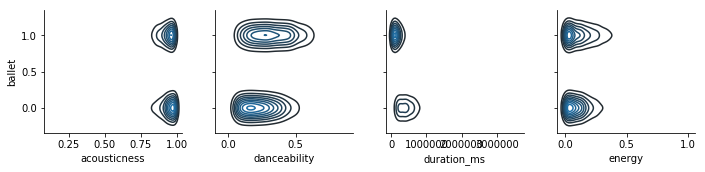

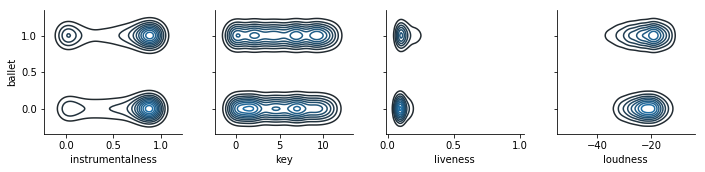

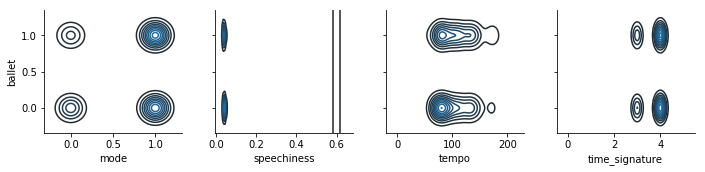

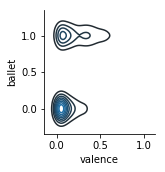

In [5]:
features_to_plot = ['acousticness', 'danceability', 'duration_ms', 'energy',
                   'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
                   'speechiness', 'tempo', 'time_signature', 'valence']
for i in range(0, 13, 4):
    g = sns.PairGrid(data,
                     x_vars = features_to_plot[i:i+4],
                     y_vars = ["ballet"])
    g = g.map(sns.kdeplot)

Okay, these look pretty darn similar. Not super surprising! However, valance isn't totally similar, which is pretty cool, since valance is a measure of 'emotion', and we see that maybe ballet music is more evocative of sadness (lower valance = sadder music, according to the documentation)? Cool!

I will note that dancability also looks a little different (hah!), as does energy, so we'll take a look at those too, but I don't feel like closer inspection will reveal them to be distributed differently enough that they could be used to distinguish the two in classification. But maybe!

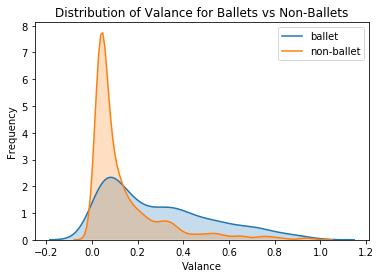

In [27]:
# plotting the distributions of valance for ballets/non ballets
ax = sns.kdeplot(data[['valence', 'ballet']][data['ballet'] == 1]['valence'], shade = True, label="ballet")
ax = sns.kdeplot(data[['valence', 'ballet']][data['ballet'] == 0]['valence'], shade = True, label="non-ballet")
ax.set_xlabel('Valance')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Valance for Ballets vs Non-Ballets')

fig = ax.get_figure()
fig.savefig("valance_dist.png", dpi=300)

Ahhhhh so cool

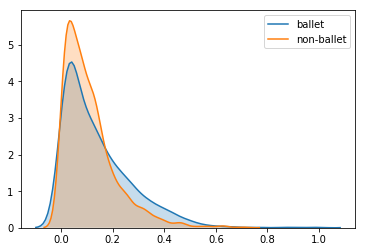

In [129]:
# plotting the distributions of energy for ballets/non ballets
sns.kdeplot(data[['energy', 'ballet']][data['ballet'] == 1]['energy'], shade = True, label="ballet")
sns.kdeplot(data[['energy', 'ballet']][data['ballet'] == 0]['energy'], shade = True, label="non-ballet")

merp, not as cool :/ 

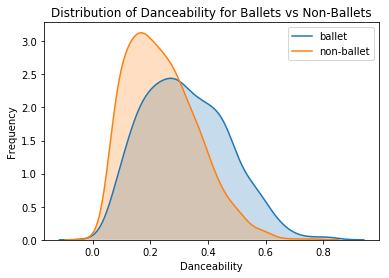

In [28]:
# plotting the distributions of danceability for ballets/non ballets
ax = sns.kdeplot(data[['danceability', 'ballet']][data['ballet'] == 1]['danceability'], shade = True, label="ballet")
ax = sns.kdeplot(data[['danceability', 'ballet']][data['ballet'] == 0]['danceability'], shade = True, label="non-ballet")
ax.set_xlabel('Danceability')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Danceability for Ballets vs Non-Ballets')

fig = ax.get_figure()
fig.savefig("danceability_dist.png", dpi=300)

My heart wants 'danceability' to matter in the classification of ballet vs nonballet.

__Results:__ It seems like valance matters on its own somewhat, along with danceability. However sometimes variables can look like they don't contribute much by themselves, but they matter a lot in the end, so I'll keep them all for now, but when I test out different models, I'll try using just ones that seem to matter from my analysis, here, as well as PCA (even though its less interpretable) to get at only what 'matters' (from a 'contribution to variation' standpoint).

## Aggregating Analysis Data
Ideas I tried out:
- number of sections/segments
- range of the durations (mean? standard deviation?)
- loudness max (in segments) -- mean
- adding pitches/timbres(sp?) could give insight into if the song has dominant high or low pitches, or if there's a mixture (especially if the max and min are also recorded in other columns)
    - if I do PCA, I might get a component that ends up taking parts of these features? 
- looking at sections
    - mean, max, min key
    - record number of major and minor sections
    - mean, max, min tempo
    - mean, max, min time signature 
- average tatum/beat/bar duration
- track has overall loudness, tempo, modality, and time signature

Other notes:
- I droped meta here -- it's not helpful to classification
- I pickled what I had in the end to use in model building

In [17]:
data.drop('meta', axis=1, inplace=True)

### Number of sections/segments
First I'll create the columns, then I'll look at some visualizations

In [5]:
data['no_segments'] = data.apply(lambda x: len(x.segments), axis=1)

In [20]:
data['no_sections'] = data.apply(lambda x: len(x.sections), axis=1)

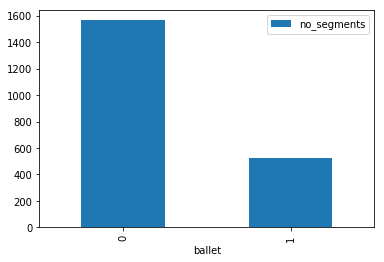

In [30]:
# nice! This looks like it actually might be helpful!
data[['no_segments', 'ballet']].groupby('ballet').mean().plot(kind='bar')

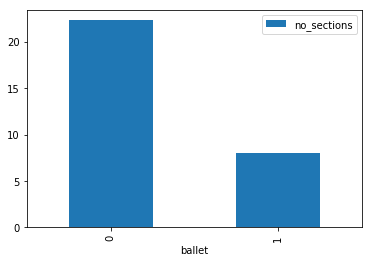

In [35]:
# same :) 
data[['no_sections', 'ballet']].groupby('ballet').mean().plot(kind='bar')

It looks like these might be helpful, but let's look at the distributions of these values for ballets and non ballets before we get too excited.

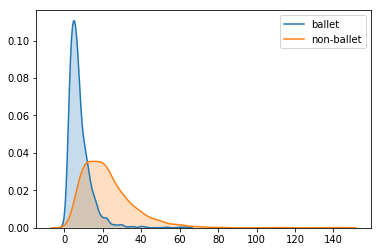

In [39]:
sns.kdeplot(data[['no_sections', 'ballet']][data['ballet'] == 1]['no_sections'], shade = True, label="ballet")
sns.kdeplot(data[['no_sections', 'ballet']][data['ballet'] == 0]['no_sections'], shade = True, label="non-ballet")

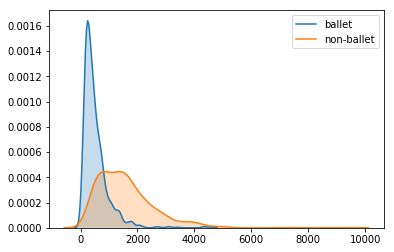

In [41]:
sns.kdeplot(data[['no_segments', 'ballet']][data['ballet'] == 1]['no_segments'], shade = True, label="ballet")
sns.kdeplot(data[['no_segments', 'ballet']][data['ballet'] == 0]['no_segments'], shade = True, label="non-ballet")

Excellent! Looks like maybe we've got two predictors on our hands. But, perhaps using both of these is redundant/introduces multicolinearity (if we're using linear regression-speak) -- I don't know how Spotify calculates sections and segments, but one may depend on the other, in which case we should just choose one. 

In [42]:
np.corrcoef(data['no_segments'], data['no_sections'])

array([[1.        , 0.95957815],
       [0.95957815, 1.        ]])

Yup, looks like we should only use one as a feature -- they're super correlated! I'll choose which one later, probably when building the model, when I can see which one has a more significant positive effect on accuracy. 

### Overall Loudness, Tempo, Time Signature, and Modality

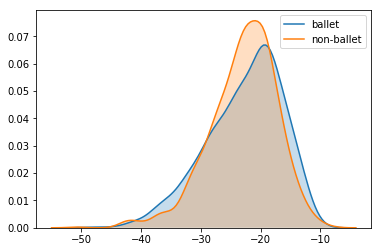

In [67]:
sns.kdeplot(data.apply(lambda x: x.track['loudness'], axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: x.track['loudness'], axis=1)[1041:], shade = True, label="non-ballet")

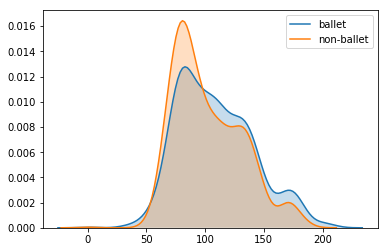

In [68]:
sns.kdeplot(data.apply(lambda x: x.track['tempo'], axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: x.track['tempo'], axis=1)[1041:], shade = True, label="non-ballet")

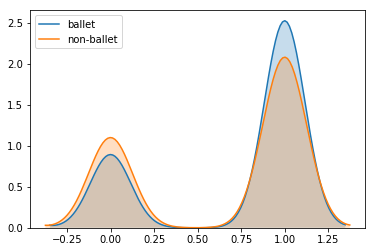

In [69]:
sns.kdeplot(data.apply(lambda x: x.track['mode'], axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: x.track['mode'], axis=1)[1041:], shade = True, label="non-ballet")

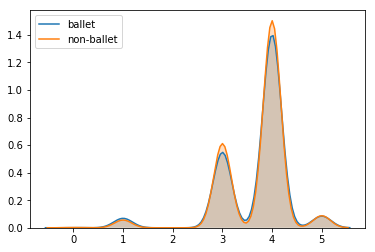

In [70]:
sns.kdeplot(data.apply(lambda x: x.track['time_signature'], axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: x.track['time_signature'], axis=1)[1041:], shade = True, label="non-ballet")

Not that helpful! We won't use these as features.

### Average Range, Mean, and Standard Deviations of Durations - Sections

/Users/hannah/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/hannah/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


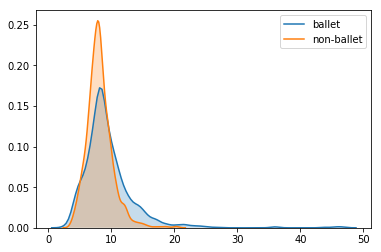

In [90]:
# plots the minimum duration for ballet & non ballet datum
sns.kdeplot(data.apply(lambda x: min([y['duration'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: min([y['duration'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[1041:], shade = True, label="non-ballet")

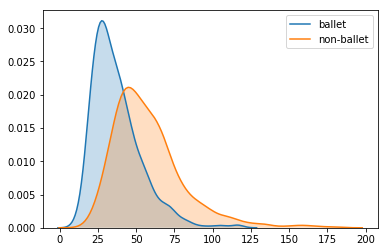

In [91]:
# plots the maximum duration for ballet and non-ballet datum
sns.kdeplot(data.apply(lambda x: max([y['duration'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: max([y['duration'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[1041:], shade = True, label="non-ballet")

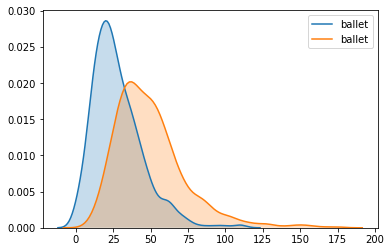

In [93]:
# plots the range of the durations for ballet and non-ballet datum
sns.kdeplot(data.apply(lambda x: max([y['duration'] for y in x.sections]) - min([y['duration'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: max([y['duration'] for y in x.sections]) - min([y['duration'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[1041:], shade = True, label="ballet")
                                                                                 

Ehh, could be helpful. I'll keep the range as a feature.

In [96]:
data['sec_duration_range'] = data.apply(lambda x: max([y['duration'] for y in x.sections]) - min([y['duration'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)


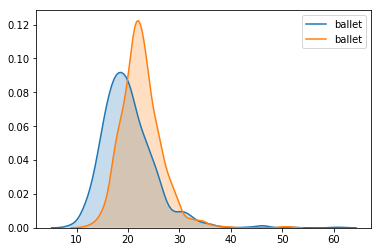

In [97]:
# plots the mean of the durations for ballet and non-ballet datum
sns.kdeplot(data.apply(lambda x: np.mean([y['duration'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: np.mean([y['duration'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[1041:], shade = True, label="ballet")
                                                                                 

There's a difference, but they share too much in common.

### Average Range, Mean, and Standard Deviations of Durations - Segments

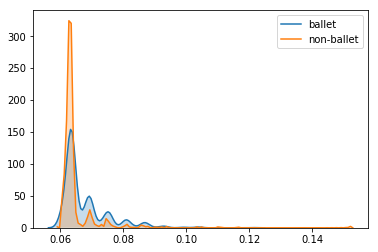

In [98]:
# plots the minimum duration for ballet & non ballet datum
sns.kdeplot(data.apply(lambda x: min([y['duration'] for y in x.segments]) if len(x.segments) > 0 else np.nan, axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: min([y['duration'] for y in x.segments]) if len(x.sections) > 0 else np.nan, axis=1)[1041:], shade = True, label="non-ballet")

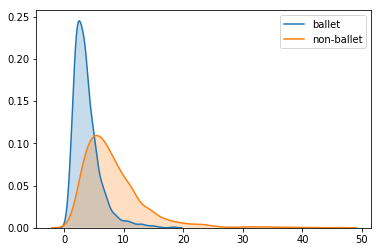

In [99]:
# plots the maximum duration for ballet and non-ballet datum
sns.kdeplot(data.apply(lambda x: max([y['duration'] for y in x.segments]) if len(x.segments) > 0 else np.nan, axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: max([y['duration'] for y in x.segments]) if len(x.segments) > 0 else np.nan, axis=1)[1041:], shade = True, label="non-ballet")

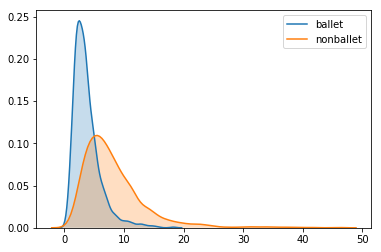

In [162]:
# plots the range of the durations for ballet and non-ballet datum
sns.kdeplot(data.apply(lambda x: max([y['duration'] for y in x.segments]) - min([y['duration'] for y in x.segments]) if len(x.segments) > 0 else np.nan, axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: max([y['duration'] for y in x.segments]) - min([y['duration'] for y in x.segments]) if len(x.segments) > 0 else np.nan, axis=1)[1041:], shade = True, label="nonballet")

Okay! Segment range is looking better than what we've seen before for the duration analysis info. Let's keep it.

In [102]:
data['seg_duration_range'] = data.apply(lambda x: max([y['duration'] for y in x.sections]) - min([y['duration'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)
                                                                                 

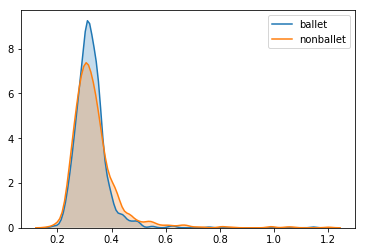

In [163]:
# plots the mean of the durations for ballet and non-ballet datum
sns.kdeplot(data.apply(lambda x: np.mean([y['duration'] for y in x.segments]) if len(x.segments) > 0 else np.nan, axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: np.mean([y['duration'] for y in x.segments]) if len(x.segments) > 0 else np.nan, axis=1)[1041:], shade = True, label="nonballet")
                                                                                 

Nope, segment duration mean is no help. 

### Digging into Section Data (loudness, key, tempo, modality, time signature)
- mean of these features within each song
- range of these features within each song

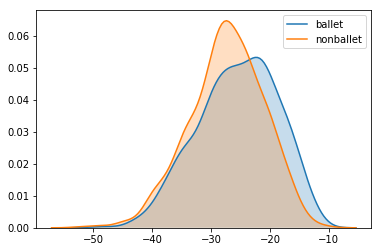

In [164]:
# taking the mean loudness
sns.kdeplot(data.apply(lambda x: np.mean([y['loudness'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: np.mean([y['loudness'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[1041:], shade = True, label="nonballet")

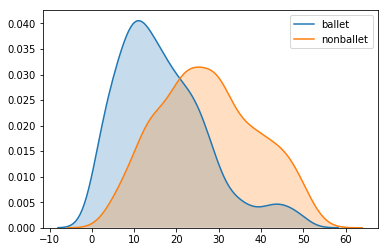

In [165]:
# taking the range of loudness
sns.kdeplot(data.apply(lambda x: max([y['loudness'] for y in x.sections]) - min([y['loudness'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: max([y['loudness'] for y in x.sections]) - min([y['loudness'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[1041:], shade = True, label="nonballet")

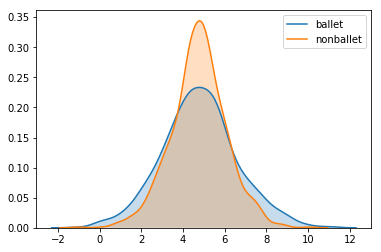

In [166]:
# taking the mean key
sns.kdeplot(data.apply(lambda x: np.mean([y['key'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: np.mean([y['key'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[1041:], shade = True, label="nonballet")

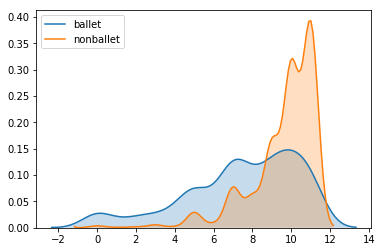

In [161]:
# taking the range of key
sns.kdeplot(data.apply(lambda x: max([y['key'] for y in x.sections]) - min([y['key'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: max([y['key'] for y in x.sections]) - min([y['key'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[1041:], shade = True, label="nonballet")

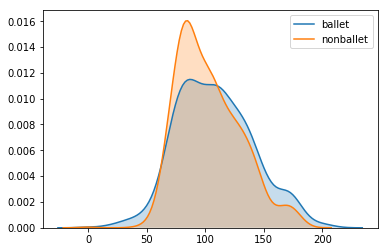

In [160]:
# taking the mean tempo
sns.kdeplot(data.apply(lambda x: np.mean([y['tempo'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: np.mean([y['tempo'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[1041:], shade = True, label="nonballet")

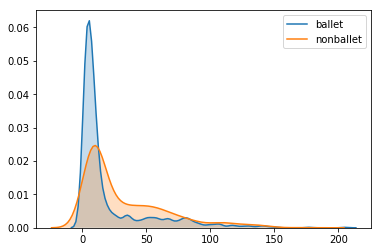

In [159]:
# taking the range of key
sns.kdeplot(data.apply(lambda x: max([y['tempo'] for y in x.sections]) - min([y['tempo'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: max([y['tempo'] for y in x.sections]) - min([y['tempo'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[1041:], shade = True, label="nonballet")

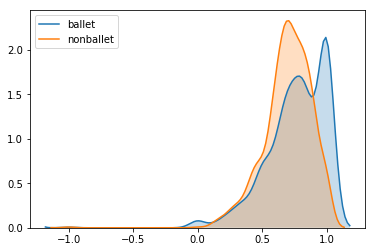

In [158]:
# taking the mean modality
sns.kdeplot(data.apply(lambda x: np.mean([y['mode'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: np.mean([y['mode'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[1041:], shade = True, label="nonballet")

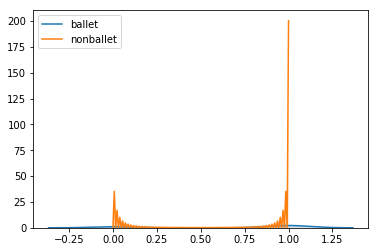

In [157]:
# taking the range of modality
sns.kdeplot(data.apply(lambda x: max([y['mode'] for y in x.sections]) - min([y['mode'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: max([y['mode'] for y in x.sections]) - min([y['mode'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[1041:], shade = True, label="nonballet")

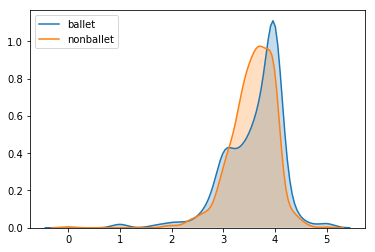

In [156]:
# taking the mean time signature
sns.kdeplot(data.apply(lambda x: np.mean([y['time_signature'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: np.mean([y['time_signature'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[1041:], shade = True, label="nonballet")

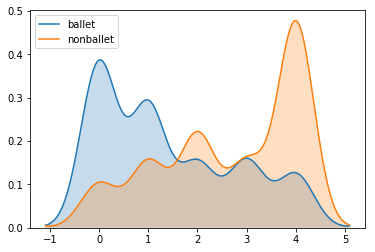

In [155]:
# taking the range of time signature
sns.kdeplot(data.apply(lambda x: max([y['time_signature'] for y in x.sections]) - min([y['time_signature'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: max([y['time_signature'] for y in x.sections]) - min([y['time_signature'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)[1041:], shade = True, label="nonballet")

The ranges seem to be significantly different! The means, less so. I'll save the ranges!

In [151]:
data['sec_loudness_range'] = data.apply(lambda x: max([y['loudness'] for y in x.sections]) - min([y['loudness'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)
data['sec_key_range'] = data.apply(lambda x: max([y['key'] for y in x.sections]) - min([y['key'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)
data['sec_tempo_range'] = data.apply(lambda x: max([y['tempo'] for y in x.sections]) - min([y['tempo'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)
data['sec_mode_range'] = data.apply(lambda x: max([y['mode'] for y in x.sections]) - min([y['mode'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)
data['sec_time_signature_range'] = data.apply(lambda x: max([y['time_signature'] for y in x.sections]) - min([y['time_signature'] for y in x.sections]) if len(x.sections) > 0 else np.nan, axis=1)


### Digging into Segment Data (loudness, pitches, timbre)
- count the number of unique pitches/timbres identified
- count the maximum of the maximum number of times that a timbre shows up
    - round the timbres to the nearest tenth, because otherwise there are just too many, too precisely measured
- average range of the timbres within segments
- range of the timbres overall
- mean pitch, without repeats (since 1 will just occur the most)
Pitches are a need something a little different than range, since they're relative to each song  -- mean may be a good bet

In [219]:
# 20BHajwSZPTbGbsFSxurtU,36Jo9Y3bVip2mLvBNbgNaN,4PJDfvW1Bw3a8fZy0C6Bjq,1Bi0JfOAavN55nKBYBoONe
data.segments

id
20BHajwSZPTbGbsFSxurtU    [{'start': 0.0, 'duration': 0.98136, 'confiden...
36Jo9Y3bVip2mLvBNbgNaN    [{'start': 0.0, 'duration': 0.50649, 'confiden...
4PJDfvW1Bw3a8fZy0C6Bjq    [{'start': 0.0, 'duration': 0.80068, 'confiden...
1Bi0JfOAavN55nKBYBoONe    [{'start': 0.0, 'duration': 0.5581, 'confidenc...
1lxgxl9HWcFbx7FYjH0yFl    [{'start': 0.0, 'duration': 0.27918, 'confiden...
69ftg7xbry9efOJuA2rr0a    [{'start': 0.0, 'duration': 0.11188, 'confiden...
4bUmsjPY6B6UnrJWiqXjaX    [{'start': 0.0, 'duration': 0.34776, 'confiden...
7plfKTRZxPXE05euh0wQmQ    [{'start': 0.0, 'duration': 0.1078, 'confidenc...
0QKbNkXMmZ7xgNHGqdkEnL    [{'start': 0.0, 'duration': 0.79429, 'confiden...
5ytXZyg6GzZQWkBvAsjkHN    [{'start': 0.0, 'duration': 0.34816, 'confiden...
7tGfCkoyBqq8xNF3NfYBTr    [{'start': 0.0, 'duration': 0.06975, 'confiden...
48KXMsFHYdc0CgpgLTuOy3    [{'start': 0.0, 'duration': 0.08703, 'confiden...
20eAkFhqVulh01GLtkJVIj    [{'start': 0.0, 'duration': 0.76635, 'confiden...
6QeMhFXRU

In [250]:
def get_pitches(segment):
    pitches = []
    for x in segment:
        for y in x['pitches']:
            pitches.append(y)
    return pitches

def get_rounded_timbres(segment):
    timbres = []
    for x in segment:
        for y in x['timbre']:
            timbres.append(round(y))
    return timbres

def get_timbre_count(timbres):
    timbre_count = {}
    for timbre in set(timbres):
        timbre_count[timbre] = timbres.count(timbre)
    return timbre_count

def get_timbre_seg_avg(segment):
    avgs = []
    for seg in segment:
        avgs.append(np.mean(seg['timbre']))
    return np.mean(avgs)

def get_pitch_seg_avg(segment):
    avgs = []
    for seg in segment:
        avgs.append(np.mean(seg['pitches']))
    return np.mean(avgs)

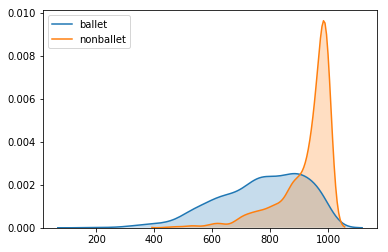

In [236]:
# plotting the number of unique pitches
sns.kdeplot(data.apply(lambda x: len(set(get_pitches(x.segments))), axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: len(set(get_pitches(x.segments))), axis=1)[1041:], shade = True, label="nonballet")

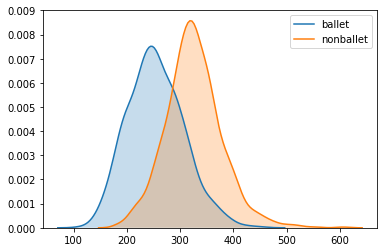

In [237]:
# plotting the number of unique timbres (this one takes a fair bit of time)
sns.kdeplot(data.apply(lambda x: len(set(get_timbre_count(get_rounded_timbres(x.segments)))), axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: len(set(get_timbre_count(get_rounded_timbres(x.segments)))), axis=1)[1041:], shade = True, label="nonballet")

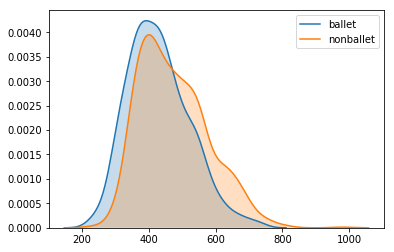

In [238]:
# plotting the range of timbres
sns.kdeplot(data.apply(lambda x: max(get_rounded_timbres(x.segments)) - min(get_rounded_timbres(x.segments)), axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: max(get_rounded_timbres(x.segments)) - min(get_rounded_timbres(x.segments)), axis=1)[1041:], shade = True, label="nonballet")

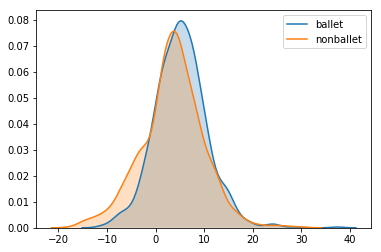

In [244]:
# plotting the avg of timbres over all segment timbre averages
sns.kdeplot(data.apply(lambda x: get_timbre_seg_avg(x.segments), axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: get_timbre_seg_avg(x.segments), axis=1)[1041:], shade = True, label="nonballet")

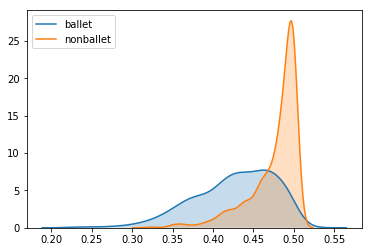

In [246]:
# plotting the mean of the pitches (unique, otherwise the mean would be close to 1 for all!)
sns.kdeplot(data.apply(lambda x: np.mean(list(set(get_pitches(x.segments)))), axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: np.mean(list(set(get_pitches(x.segments)))), axis=1)[1041:], shade = True, label="nonballet")

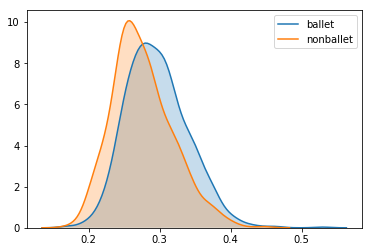

In [253]:
# plotting the avg of timbres over all segment timbre averages
sns.kdeplot(data.apply(lambda x: get_pitch_seg_avg(x.segments), axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: get_pitch_seg_avg(x.segments), axis=1)[1041:], shade = True, label="nonballet")

In [240]:
data['no_unique_pitches'] = data.apply(lambda x: len(set(get_pitches(x.segments))), axis=1)
data['no_unique_timbres'] = data.apply(lambda x: len(set(get_timbre_count(get_rounded_timbres(x.segments)))), axis=1)

In [247]:
data['mean_pitch'] = data.apply(lambda x: np.mean(list(set(get_pitches(x.segments)))), axis=1)

### Average Length of Tatums/Beats/Bars

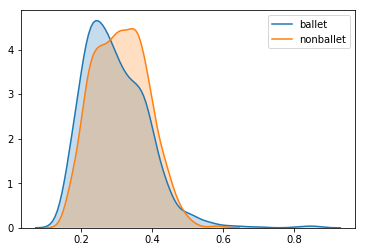

In [154]:
# taking the mean duration for tatums
sns.kdeplot(data.apply(lambda x: np.mean([y['duration'] for y in x.tatums]), axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: np.mean([y['duration'] for y in x.tatums]), axis=1)[1041:], shade = True, label="nonballet")


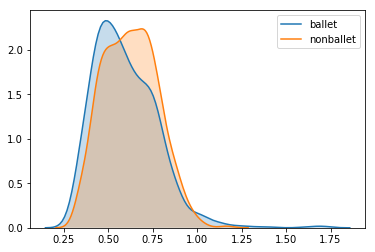

In [153]:
# taking the mean duration for beats
sns.kdeplot(data.apply(lambda x: np.mean([y['duration'] for y in x.beats]), axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: np.mean([y['duration'] for y in x.beats]), axis=1)[1041:], shade = True, label="nonballet")


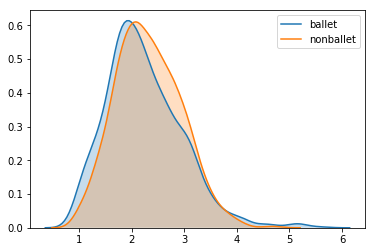

In [152]:
# taking the mean for bars
sns.kdeplot(data.apply(lambda x: np.mean([y['duration'] for y in x.bars]), axis=1)[:1041], shade = True, label="ballet")
sns.kdeplot(data.apply(lambda x: np.mean([y['duration'] for y in x.bars]), axis=1)[1041:], shade = True, label="nonballet")


I'm not overly eager to include this data -- doesn't seem too revealing.

## Finalize the data set!
- drop unnecessary columns
- pickle!

In [254]:
data

,bars,beats,sections,segments,tatums,track,acousticness,danceability,duration_ms,energy,...,sec_duration_range,seg_duration_range,sec_loudness_range,sec_key_range,sec_tempo_range,sec_mode_range,sec_time_signature_range,no_unique_pitches,no_unique_timbres,mean_pitch
id,,,,,,,,,,,,,,,,,,,,,
20BHajwSZPTbGbsFSxurtU,"[{'start': 2.37543, 'duration': 2.51862, 'conf...","[{'start': 1.04131, 'duration': 0.67416, 'conf...","[{'start': 0.0, 'duration': 45.2725, 'confiden...","[{'start': 0.0, 'duration': 0.98136, 'confiden...","[{'start': 1.04131, 'duration': 0.44944, 'conf...","{'num_samples': 3134628, 'duration': 142.16, '...",0.948,0.1610,142160,0.00474,...,36.51099,36.51099,12.996,8.0,17.155,1.0,1.0,806,288,0.441292
36Jo9Y3bVip2mLvBNbgNaN,"[{'start': 0.34114, 'duration': 0.95762, 'conf...","[{'start': 0.34114, 'duration': 0.47535, 'conf...","[{'start': 0.0, 'duration': 4.93738, 'confiden...","[{'start': 0.0, 'duration': 0.50649, 'confiden...","[{'start': 0.34114, 'duration': 0.3169, 'confi...","{'num_samples': 2010372, 'duration': 91.17333,...",0.506,0.1610,91173,0.05640,...,24.73630,24.73630,11.151,7.0,9.006,1.0,1.0,782,210,0.437831
4PJDfvW1Bw3a8fZy0C6Bjq,"[{'start': 0.59006, 'duration': 1.91355, 'conf...","[{'start': 0.59006, 'duration': 0.95548, 'conf...","[{'start': 0.0, 'duration': 12.75043, 'confide...","[{'start': 0.0, 'duration': 0.80068, 'confiden...","[{'start': 0.59006, 'duration': 0.63698, 'conf...","{'num_samples': 3115518, 'duration': 141.29333...",0.967,0.1050,141293,0.08010,...,24.77672,24.77672,26.506,10.0,6.758,1.0,1.0,870,272,0.461314
1Bi0JfOAavN55nKBYBoONe,"[{'start': 1.88453, 'duration': 2.37082, 'conf...","[{'start': 0.65235, 'duration': 0.61783, 'conf...","[{'start': 0.0, 'duration': 10.14338, 'confide...","[{'start': 0.0, 'duration': 0.5581, 'confidenc...","[{'start': 0.65235, 'duration': 0.30892, 'conf...","{'num_samples': 1932756, 'duration': 87.65333,...",0.949,0.3970,87653,0.32800,...,8.83480,8.83480,11.483,9.0,6.131,1.0,3.0,831,275,0.462915
1lxgxl9HWcFbx7FYjH0yFl,"[{'start': 1.4702, 'duration': 2.24442, 'confi...","[{'start': 0.30137, 'duration': 0.59597, 'conf...","[{'start': 0.0, 'duration': 8.15456, 'confiden...","[{'start': 0.0, 'duration': 0.27918, 'confiden...","[{'start': 0.30137, 'duration': 0.29798, 'conf...","{'num_samples': 1332702, 'duration': 60.44, 's...",0.978,0.3810,60440,0.33600,...,19.01551,19.01551,14.285,5.0,7.188,0.0,1.0,767,252,0.425802
69ftg7xbry9efOJuA2rr0a,"[{'start': 0.15514, 'duration': 2.41201, 'conf...","[{'start': 0.15514, 'duration': 0.61601, 'conf...","[{'start': 0.0, 'duration': 11.89862, 'confide...","[{'start': 0.0, 'duration': 0.11188, 'confiden...","[{'start': 0.15514, 'duration': 0.308, 'confid...","{'num_samples': 6959274, 'duration': 315.61333...",0.947,0.1240,315613,0.04580,...,32.14247,32.14247,16.092,8.0,10.116,1.0,4.0,936,322,0.476991
4bUmsjPY6B6UnrJWiqXjaX,"[{'start': 1.32633, 'duration': 2.94129, 'conf...","[{'start': 0.63096, 'duration': 0.69537, 'conf...","[{'start': 0.0, 'duration': 23.57802, 'confide...","[{'start': 0.0, 'duration': 0.34776, 'confiden...","[{'start': 0.63096, 'duration': 0.46358, 'conf...","{'num_samples': 3181668, 'duration': 144.29333...",0.970,0.1230,144293,0.01880,...,14.21498,14.21498,10.333,11.0,6.321,1.0,3.0,694,323,0.401239
7plfKTRZxPXE05euh0wQmQ,"[{'start': 0.06638, 'duration': 1.40132, 'conf...","[{'start': 0.06638, 'duration': 0.35342, 'conf...","[{'start': 0.0, 'duration': 10.15933, 'confide...","[{'start': 0.0, 'duration': 0.1078, 'confidenc...","[{'start': 0.06638, 'duration': 0.17671, 'conf...","{'num_samples': 3141978, 'duration': 142.49333...",0.960,0.2980,142493,0.20900,...,20.46582,20.46582,12.125,7.0,8.468,1.0,0.0,896,268,0.468978
0QKbNkXMmZ7xgNHGqdkEnL,"[{'start': 4.24318, 'duration': 4.48652, 'conf...","[{'start': 0.86141, 'duration': 1.163, 'confid...","[{'start': 0.0, 'duration': 15.45974, 'confide...","[{'start': 0.0, 'duration': 0.79429, 'confiden...","[{'start': 0.86141, 'duration': 0.77533, 'conf...","{'num_sampl

In [255]:
final_data = data

In [258]:
final_data.drop(['bars', 'beats', 'sections', 'segments', 'tatums', 'track'], axis=1, inplace=True)

In [259]:
with open('model_data.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(final_data, f, pickle.HIGHEST_PROTOCOL)